In [1]:
# Importing the reqired basic modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style()
sns.set()
import scipy.stats as stats
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn import preprocessing

### Loading the new dataset

In [2]:
# importing the file into a dataframe and displaying the rows
strength=pd.read_csv('concrete.csv')
strength

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,270,55.06


#### Deliverable 1 - EDA

In [3]:
#checking for null/NA values and printing info
print("Count of null values=",strength.isna().sum().sum())
print(strength.info());

Count of null values= 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB
None


In [4]:
### Adding the central values,skewness, standard deviation and quartiles in a dataframe
describedf=strength.describe().T
describedf['range']=describedf['max']-describedf['min']
describedf.drop(columns='count', inplace=True)
describedf['median']=strength.median()
describedf['skewness']=strength.skew()
describedf

,mean,std,min,25%,50%,75%,max,range,median,skewness
cement,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0,438.00,272.900,0.509481
slag,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4,359.40,22.000,0.800717
ash,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1,200.10,0.000,0.537354
water,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0,125.20,185.000,0.074628
superplastic,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2,32.20,6.400,0.907203
coarseagg,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0,344.00,968.000,-0.040220
fineagg,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6,398.60,779.500,-0.253010
age,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0,364.00,28.000,3.269177
strength,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6,80.27,34.445,0.416977


The analysis of the above df shows that attribute age is highly right skewed, while all other attributes except courseagg and fineagg are slightly right skewed, while the two are slightly left skewed.
The difference between the mean and median values of the slag,ash and age suggest the distribution of these attributes is not normal.

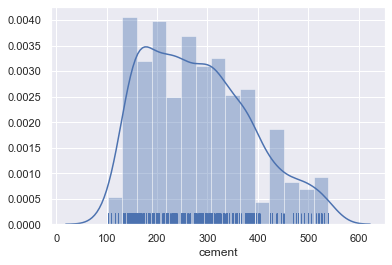

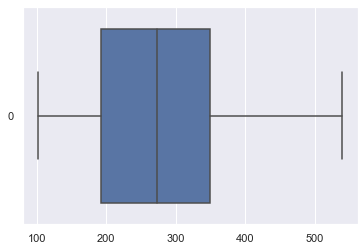

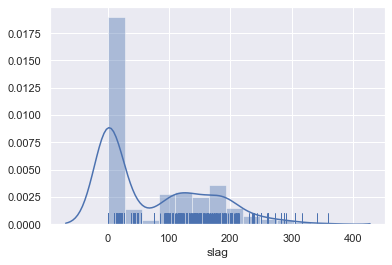

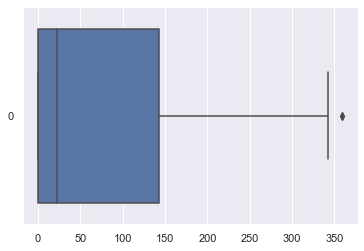

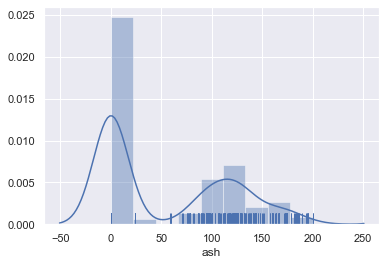

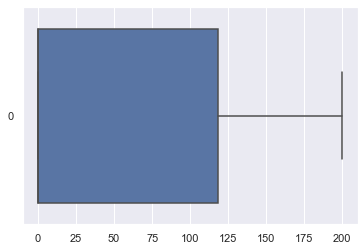

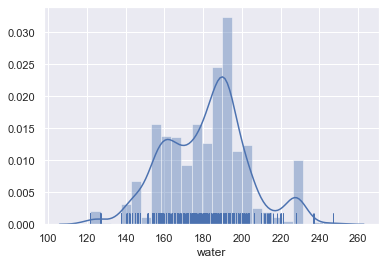

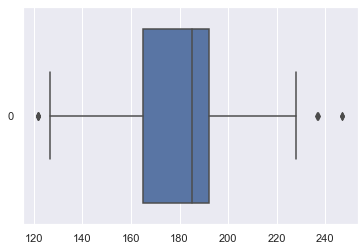

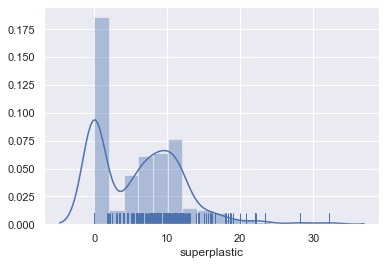

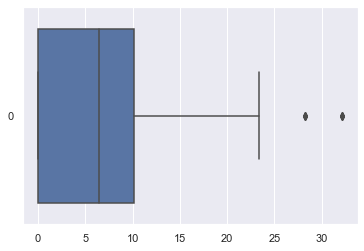

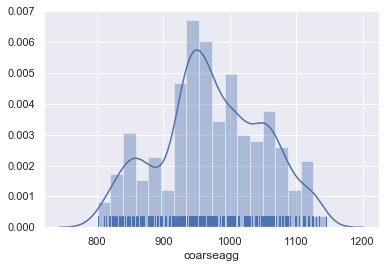

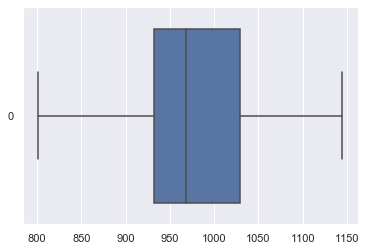

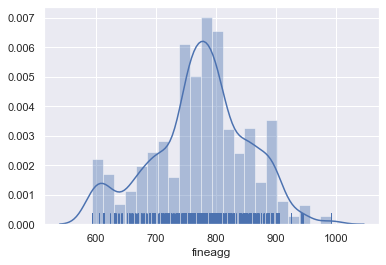

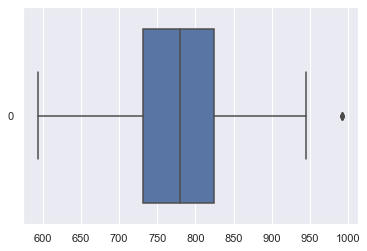

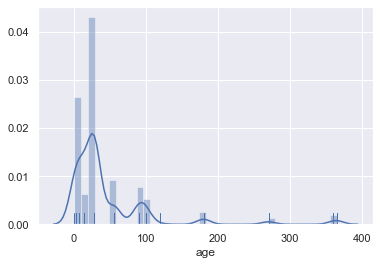

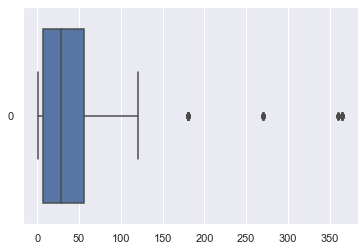

In [5]:
for i in strength.columns[:-1]:
    sns.distplot(strength[i],rug=True)
    plt.show()
    sns.boxplot(data=strength[i],orient='h')
    plt.show();

Based on the above graphs, following conclusions can be made regarding the original data:
1. The assumption that slag, ash and age are not normally distributed is supported by the graphs.
2. Cement shows an almost normal distrbution and donot exhibit outliers.
3. Slag, ash, superplastic and fineagg suggest two gaussians with outliers present except for ash
4. water and courseagg suggest three gaussians while age displays multiple gaussians with no outliers in courseagg.

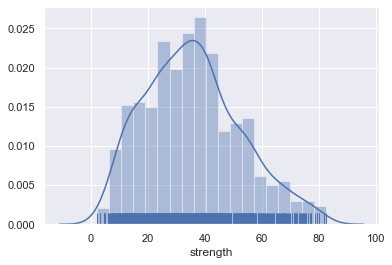

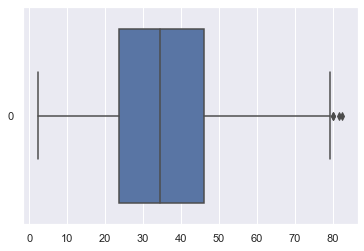

In [6]:
## Target Variable

sns.distplot(strength['strength'],rug=True)
plt.show()
sns.boxplot(data=strength['strength'],orient='h')
plt.show();

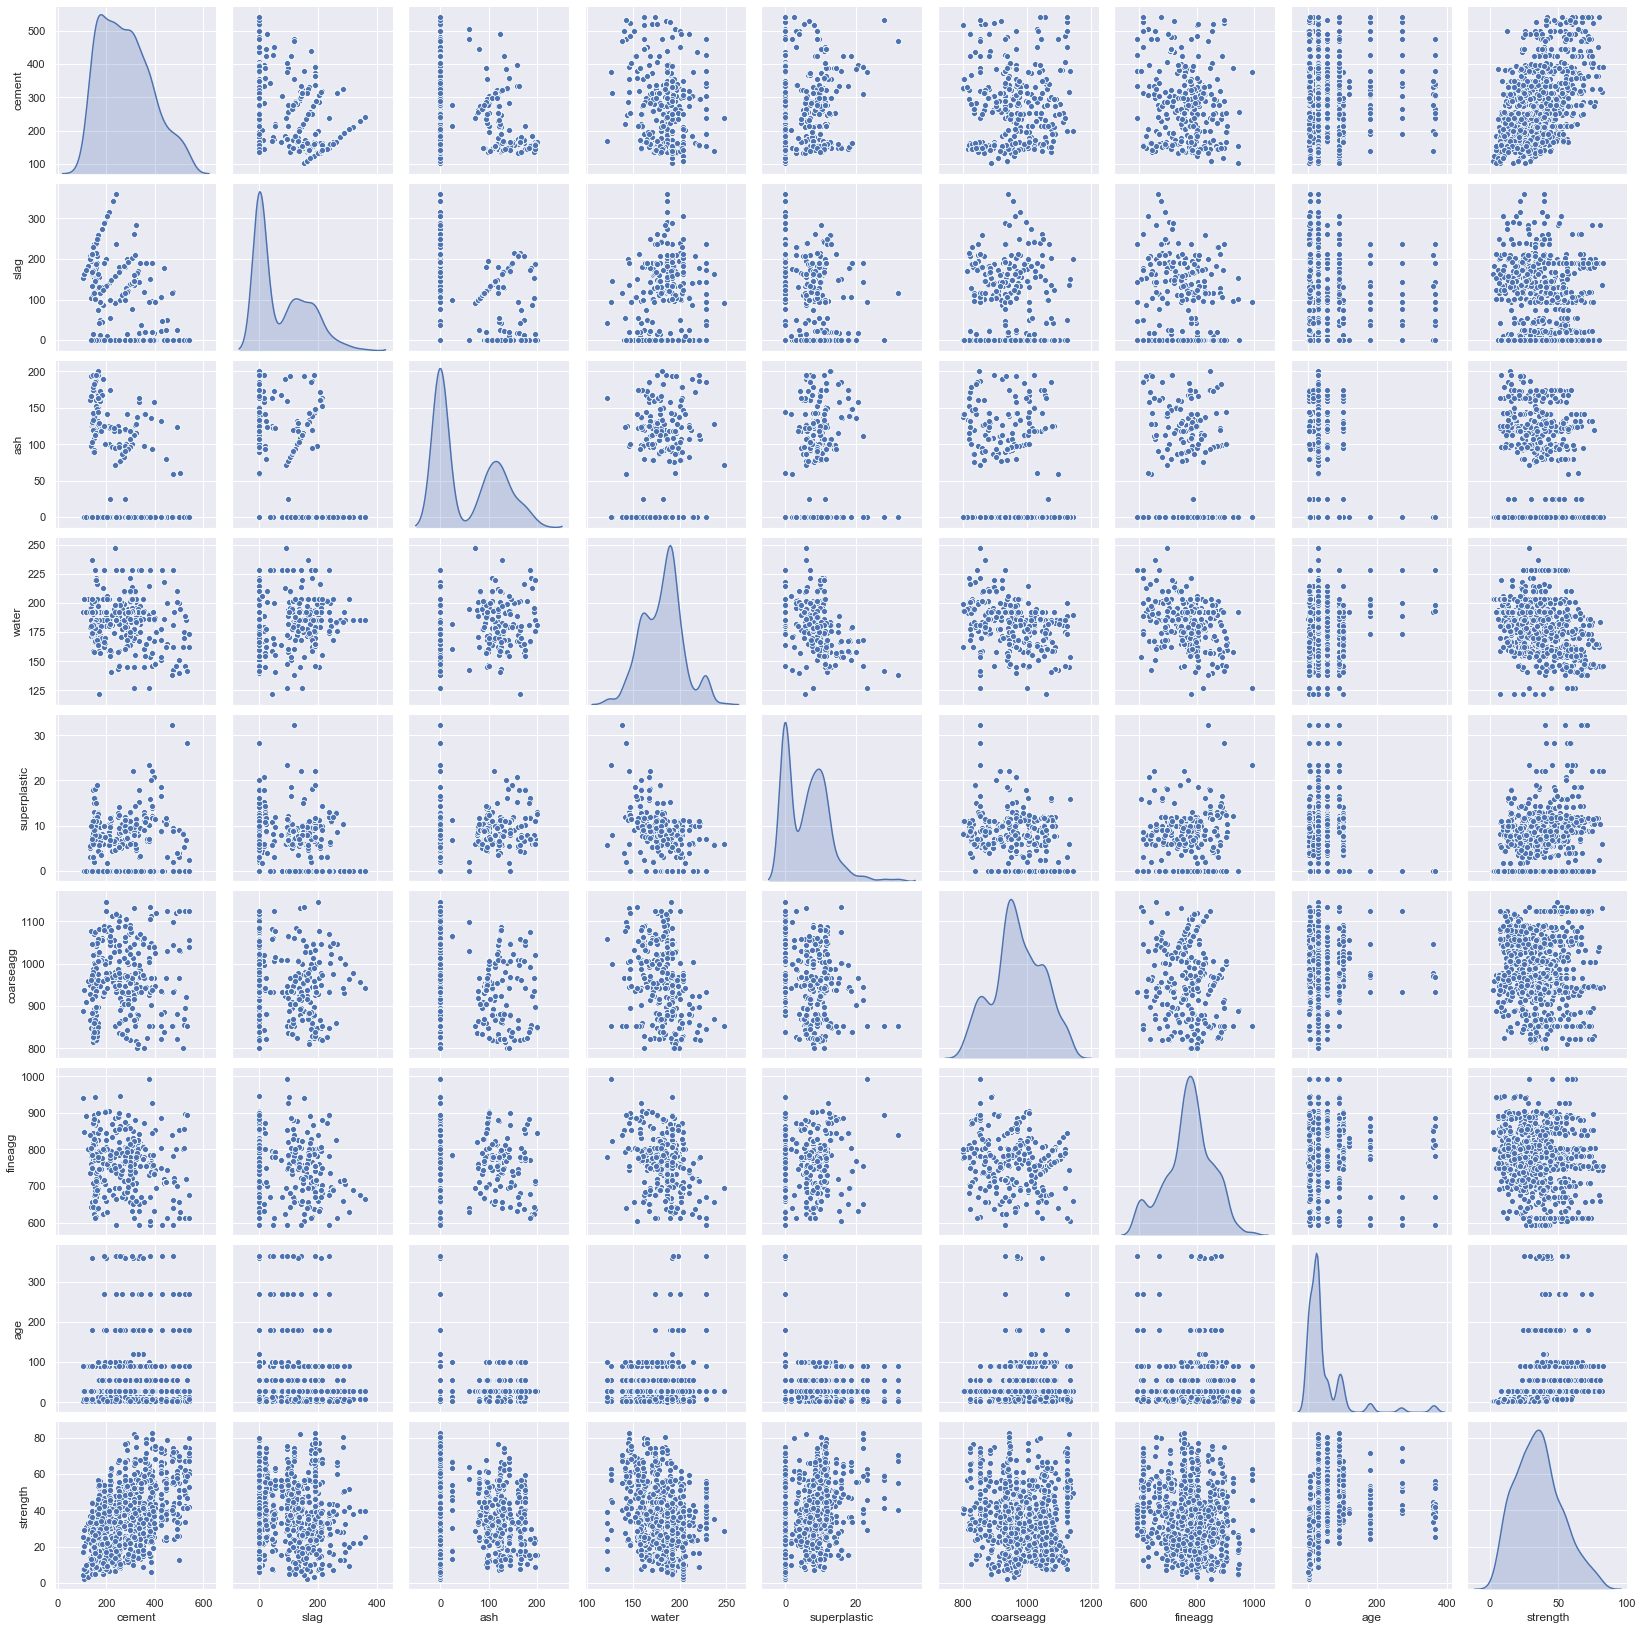

In [7]:
sns.pairplot(strength,diag_kind='kde')
plt.show();

Based on above pair plot analysis following observations can be made:
1. Low correlation exists between most of the features as indiacted by respective scatter plots.
2. High correlation doesn't seem to exist between any two features for the whole data.

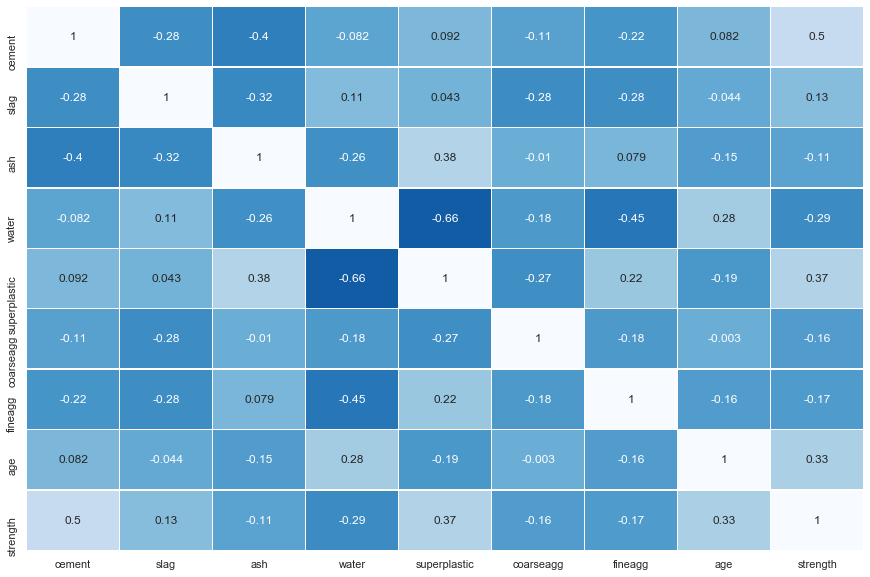

In [8]:
## Plotting the correlation matrix on a heatmap
plt.figure(figsize=[15,10])
sns.heatmap(strength.corr(), 
            cmap='Blues_r',
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False
           )
plt.show();

The heatmap confirms the relation between features as observed in pairplot.

##### Since there are outliers present in data, we replace the outliers with the mean/median value. Since the outliers are far spread, we impute outliers with median values.

In [9]:
## replacing outliers with median values
for j in strength.columns[:-1]:
    Q1 = strength[j].quantile(0.25)
    Q3 = strength[j].quantile(0.75)
    IQR = Q3 - Q1
    strength.loc[(strength[j] < (Q1 - (1.5*IQR))) | (strength[j] > (Q3 + (1.5*IQR))),j] = strength[j].median()

##### we can remove the rows still consisting of outliers based on z score value greater than 3 and create model on the remaining dataset.

In [10]:
#find absolute value of z-score for each observation
z = np.abs(stats.zscore(strength))

#only keep rows in dataframe with all z-scores less than absolute value of 3 
strength = strength[(z<3).all(axis=1)]

#find how many rows are left in the dataframe 
print(strength.shape)

(1020, 9)


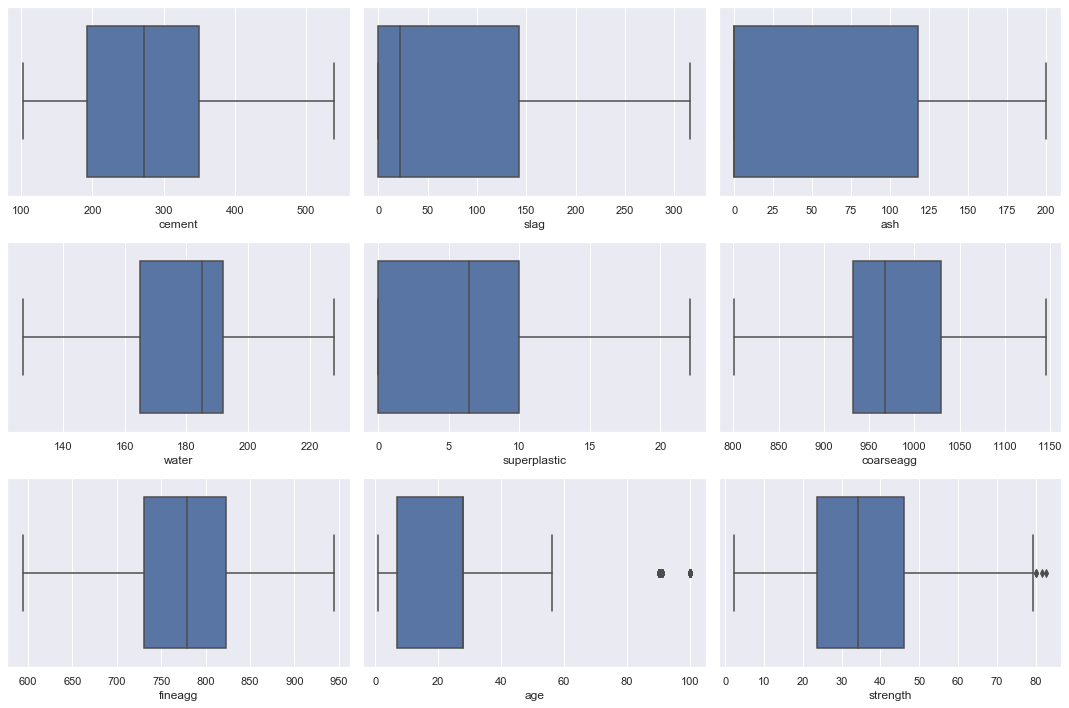

In [11]:
#creating boxplot to check the outliers after replacing with median
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize=(15,10))
axs = axs.flatten()
for i in range(0,len(strength.columns)):
    sns.boxplot(strength.iloc[:,i],ax=axs[i])
plt.tight_layout()
plt.show()

The above plots show how the cleaned data contains minimal outliers.

##### Deliverable 2 - Feature Engineering

###### Since all the features show low correlation with each other and does not seem to exhibit a dependence relation for allowing composition, No composite feature can be formed nor can any feature be dropped at this point.

###### To determine the model complexity, we use PolynomialFeatures of preprocessing to compare the scores of model for original and polynomial features

In [12]:
from sklearn.linear_model import LinearRegression

X = strength.drop('strength',axis=1)
Y = strength['strength']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state=10)

reg = LinearRegression()
reg.fit(X_train,Y_train)
scores = pd.DataFrame({ 'Linear reg on Original features': [reg.score(X_test,Y_test)]})

In [13]:
poly = preprocessing.PolynomialFeatures(degree = 2)

X_poly = poly.fit_transform(X)
X_train_poly, X_test_poly, Y_train_poly, Y_test_poly = train_test_split(X_poly,Y,test_size=0.3,random_state=10)

print('The shape of the transformed(polynomial) dataset is:',X_poly.shape)

reg = LinearRegression()
reg.fit(X_train_poly,Y_train_poly)

scores['Linear reg on Polynomial features'] = reg.score(X_test_poly,Y_test)
scores

The shape of the transformed(polynomial) dataset is: (1020, 45)


,Linear reg on Original features,Linear reg on Polynomial features
0,0.699359,0.815141


Since the scores increased with higher degree, we can conclude that a higher degree complex model would be better suited for this dataset.


###### Exploring the gaussians

By analyzing pair plots we can see that there are multiple gaussian presnts in some of variable like - ash, water and age etc.


So we will do cluster analysis to find if there is any cluster presents in data

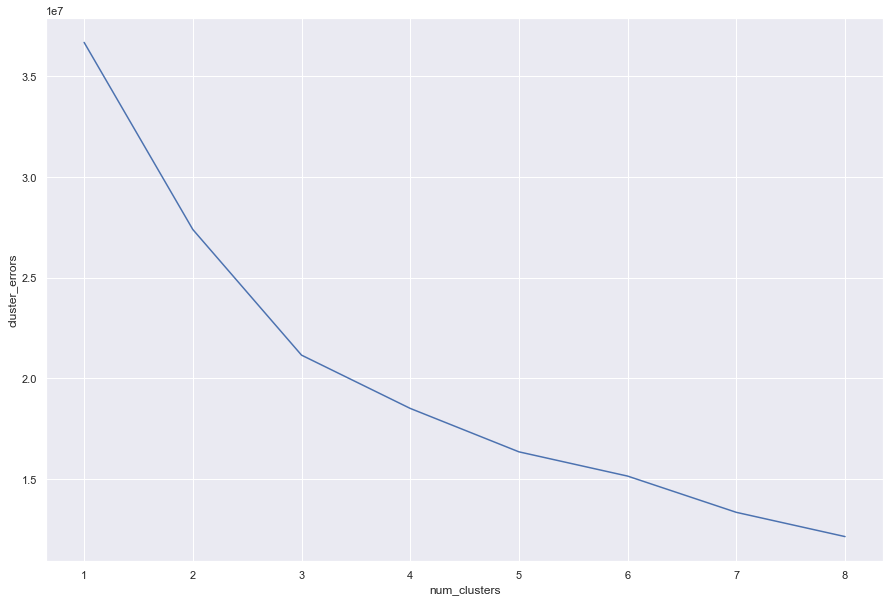

In [14]:
from sklearn.cluster import KMeans
cluster_range = range(1,9)
cluster_errors = []
for num_clusters in cluster_range:
    clusters = KMeans(num_clusters, n_init = 5)
    clusters.fit(strength)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    cluster_errors.append(clusters.inertia_)

clusters_df = pd.DataFrame({"num_clusters": cluster_range, "cluster_errors": cluster_errors})
plt.figure(figsize=(15,10))
sns.lineplot(clusters_df['num_clusters'],clusters_df['cluster_errors']);

We can see that the dataset has 3 different clusters. Now, using n_clusters as 3 we can build the model.

In [15]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(strength)
strength_cluster = strength.copy()
strength_cluster['cluster'] = kmeans.predict(strength)
strength_cluster

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,cluster
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28.0,29.89,1
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14.0,23.51,2
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28.0,29.22,2
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28.0,45.85,1
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28.0,18.29,1
...,...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28.0,13.29,2
1026,531.3,0.0,0.0,141.8,6.4,852.1,893.7,3.0,41.30,0
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28.0,44.28,1
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,28.0,55.06,0


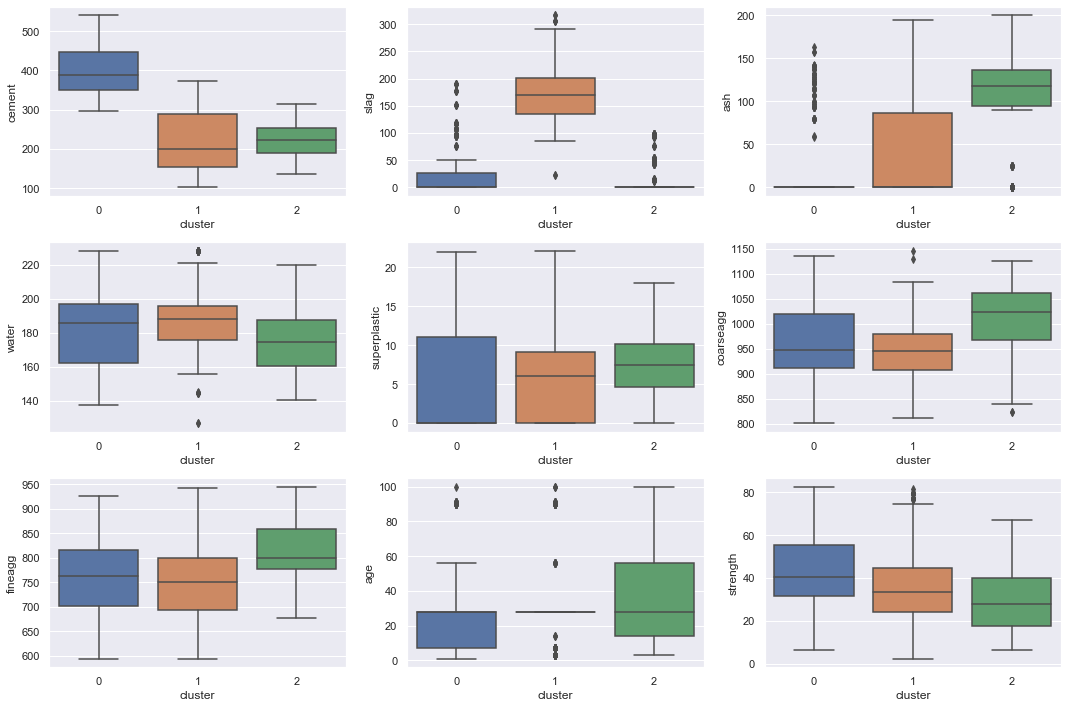

In [16]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize=(15,10))
axs = axs.flatten()
cols = len(strength_cluster.columns)-1
for i in range(0,cols):
    sns.boxplot(x='cluster', y=strength_cluster.iloc[:,i],data=strength_cluster,ax=axs[i])
plt.tight_layout()

cement, slag, ash and age clearly show the presence of three different clusters, hence are better suitable to predict the strength of the concrete.The remaining features have similar ranges for the different clusters, and so are not as suitable in pediction.However, we can decide later if any features need to be removed based on the performance of the model.

In [17]:
## Splitting the dataset into input variables and target variable 
## Taking class as target variable
X_val=strength.drop(columns='strength')
Y_val=strength['strength']
# Applying Zscore on input variables to balance the scale.
XScaled=X_val.apply(stats.zscore)

X_train, X_test, y_train, y_test = train_test_split(XScaled, Y_val, test_size=0.3, random_state=10)

In [18]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50, random_state=10)
rf.fit(X_train,y_train)

model_scores = pd.DataFrame({'Method':['Random Forest'], 'Accuracy': [rf.score(X_test, y_test)]})

from sklearn.ensemble import BaggingRegressor

br = BaggingRegressor(n_estimators=50,bootstrap=True, random_state=10)
br.fit(X_train, Y_train)

temp = pd.DataFrame({'Method':['Bagging'], 'Accuracy': [br.score(X_test, y_test)]})

model_scores = pd.concat([model_scores, temp])

from sklearn.ensemble import AdaBoostRegressor

adb = AdaBoostRegressor(n_estimators=50,learning_rate=0.1, random_state=10)
adb.fit(X_train, y_train)

temp = pd.DataFrame({'Method':['Adaptive Boosting'], 'Accuracy': [adb.score(X_test, y_test)]})

model_scores = pd.concat([model_scores, temp])

from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=50,learning_rate=0.1, random_state=10)
gbr.fit(X_train, y_train)

temp = pd.DataFrame({'Method':['Gradient Boosting'], 'Accuracy': [gbr.score(X_test, y_test)]})

model_scores = pd.concat([model_scores, temp])

model_scores.index = model_scores.Method
model_scores.drop('Method',axis=1,inplace=True)

## Selecting the best model

model_scores*100


,Accuracy
Method,
Random Forest,88.924250
Bagging,89.086536
Adaptive Boosting,73.099161
Gradient Boosting,85.906657


As can be seen above, the Random Forest algorithm gives the maximum accuracy compared to others. Hence we will be using Random Forest to build model.

###### Feature importance:

cement          35.251763
age             31.617659
slag            10.371528
water            9.094506
superplastic     5.943592
fineagg          3.318359
coarseagg        2.948622
ash              1.453971
dtype: float64


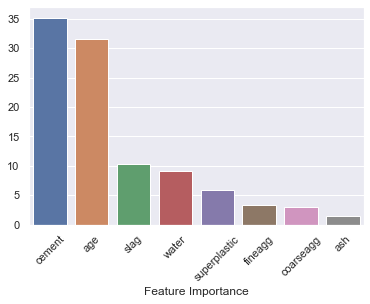

In [19]:
feature_importance = pd.Series(rf.feature_importances_)
features = strength.drop(columns='strength').columns
feature_importance.index = features
feature_importance.sort_values(ascending=False,inplace=True)
print(feature_importance*100)
sns.barplot(feature_importance.index,feature_importance*100);
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.xlabel('Feature Importance')
plt.show()

cement, age, slag and water has higer feature importance so we can try building model with only these features as below and observe model performace

In [20]:
X1 = strength.drop(columns=['strength','ash','coarseagg','fineagg'])
y1 = strength['strength']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1, test_size=0.3,random_state=10)

kfold = KFold(n_splits=10)

#cross validation after removing three features
rf_model = RandomForestRegressor(n_estimators=50, random_state=10)
results_modified = cross_val_score(rf_model, X_train1, y_train1, cv=kfold)
print("Mean accuracy of the model after dropping three features:",results_modified.mean()*100)

#cross validation with all features
result_all = cross_val_score(rf_model, X_train, y_train, cv=kfold)
print("Mean accuracy of the model with all features:",result_all.mean()*100)


Mean accuracy of the model after dropping three features: 89.25017503104019
Mean accuracy of the model with all features: 89.73135446341931


As Random forest has given the best accuracy among all these regression algortihms so we will try to improve the model performance by passing hyper parameters to Grid search 

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": [10, 20, 30, 40],
              "max_features": ['auto','sqrt'],
              "min_samples_split": [2, 3],
              "min_samples_leaf": [1, 3],
              "bootstrap": [True, False],
              "criterion": ["mse","mae"]}

grid_search = GridSearchCV(RandomForestRegressor(random_state=10), param_grid = param_grid, cv=5, verbose = 2, n_jobs= 4)
grid_search.fit(X_train,y_train)

print(" Best cross-validation accuracy:",grid_search.best_score_*100)
print(" Best parameters: ", grid_search.best_params_) 

grid_search.fit(X_train1,y_train1)

print(" Best cross-validation accuracy:",grid_search.best_score_*100)
print(" Best parameters: ", grid_search.best_params_) 

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   30.7s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 640 out of 640 | elapsed:  5.7min finished


 Best cross-validation accuracy: 89.45940400326971
 Best parameters:  {'bootstrap': True, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}
Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   25.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 640 out of 640 | elapsed:  4.3min finished


 Best cross-validation accuracy: 89.33307005643674
 Best parameters:  {'bootstrap': False, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3}


In [22]:
##Using Random Search CV to check if the performance can be improved

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {"max_depth": [10,20,30,40],
              "max_features": randint(1, 11),
              "min_samples_split": randint(2, 11),
              "min_samples_leaf": randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["mse", "mae"]}

random_search = RandomizedSearchCV(RandomForestRegressor(random_state=10), param_distributions = param_dist, cv=5, verbose = 2, n_jobs= 4)
random_search.fit(X_train,y_train)

print(" Best cross-validation accuracy:",random_search.best_score_*100)
print(" Best parameters: ", random_search.best_params_) 

random_search.fit(X_train1,y_train1)

print(" Best cross-validation accuracy:",random_search.best_score_*100)
print(" Best parameters: ", random_search.best_params_) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   10.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   17.1s finished


 Best cross-validation accuracy: 87.64889109454934
 Best parameters:  {'bootstrap': True, 'criterion': 'mae', 'max_depth': 30, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 6}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  41 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.6s finished


 Best cross-validation accuracy: 87.70379431198998
 Best parameters:  {'bootstrap': False, 'criterion': 'mse', 'max_depth': 30, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8}


In [23]:
## Building model using best parameters

random_forest_reg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30, max_features='auto',
                                          min_samples_leaf=1, min_samples_split=3,random_state=10)
random_forest_reg.fit(X_train,y_train)

print("Model Accuracy on train set:", random_forest_reg.score(X_train, y_train))
print("Model Accuracy on test set:", random_forest_reg.score(X_test, y_test))

Model Accuracy on train set: 0.9798570313044781
Model Accuracy on test set: 0.8914440556418902


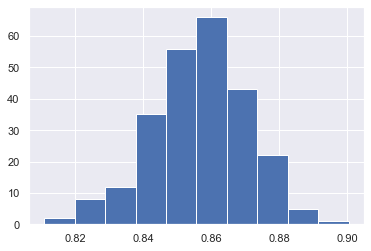

95.0 confidence interval: 82.6% and 88.2%


In [24]:
from sklearn.utils import resample

data = pd.read_csv('concrete.csv')
values = data.values

n_iterations = 250              # Number of bootstrap samples to create
n_size = int(len(data) * 0.50)    # picking only 50 % of the given data in every bootstrap sample

# run bootstrap
stats = list()
for i in range(n_iterations):
    # prepare train and test sets
    train = resample(values, n_samples=n_size)
    # picking rest of the data not considered in sample
    test = np.array([x for x in values if x.tolist() not in train.tolist()])  
    # fit model
    model = RandomForestRegressor(random_state=10)
    model.fit(train[:,:-1], train[:,-1])
    # evaluate model
    predictions = model.predict(test[:,:-1])
    score = model.score(test[:,:-1], test[:,-1])
    stats.append(score)
# plot scores
plt.hist(stats)
plt.show()
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))  
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.1f confidence interval: %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

### Conclusions:

1. Higher order polynomial model has performed better than linear model so a complex model is better for this given dataset.

2. Random forest has given the best model performance.

3. Features - cement, age, slag  water and superplastic exhibits more importance so final model was built using these feature.

4. Grid Search was used to enhanced the model performance and test accuracy was 89%.

5. For confidence interval of 95% , Model performance lies within range of 82.6% and 88.2% while the best test accuraycy is 89%